## Purpose:
This notebook evaluates multiple clustering methods on a small random sample of trials to determine which representation (raw, PCA, chunked, chunked+PCA) and which algorithm (KMeans, CURE, Agglomerative) works best.

## What is being done:
- Randomly select a subset of trials (e.g., 8–12) from the full dataset.
- For each trial, compute four data representations:
Raw time bins
PCA-reduced raw features
Chunked raw features (averaging over fixed windows)
Chunked PCA features
- For each representation, apply multiple clustering algorithms:
K-means
CURE
Agglomerative clustering
- For each algorithm/representation combination, compute clustering-quality metrics:
Davies–Bouldin score (lower = better)
Silhouette score (higher = better)
Within-Cluster Sum of Squares (WCSS)
Cluster size distributions
- plot comparisons for each representation and algorithm to identify which methods produce meaningful clusters.
## Why:
This notebook is an exploratory diagnostic step. By testing clustering performance on a smaller sample of trials, can choose the best method for each representation before scaling up to the entire dataset.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import h5py

import clustering_util_full as cu

sns.set(style="whitegrid")


In [ ]:
# Adjust path to dataset root when running
data_root = Path("Final Project/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final")
csv_path = Path("trial_index.csv")

if csv_path.exists():
    print("Loading pre-built df_trials from CSV...")
    df_trials = pd.read_csv(csv_path)
else:
    print("Scanning HDF5 dataset to build df_trials...")
    trial_list = []
    for session_dir in sorted(data_root.glob("t15.*")):
        for split in ["train", "val", "test"]:
            h5_path = session_dir / f"data_{split}.hdf5"
            if not h5_path.exists():
                continue
            
            with h5py.File(h5_path, "r") as h5:
                for trial_key in h5.keys():
                    if trial_key.startswith("trial_"):
                        trial_list.append({
                            "session": session_dir.name,
                            "split": split,
                            "trial": trial_key,
                            "path": str(h5_path)
                        })
    df_trials = pd.DataFrame(trial_list)
    df_trials.to_csv(csv_path, index=False)

df_trials.head(), len(df_trials)


Loading pre-built df_trials from CSV...


(          session  split       trial  \
 0  t15.2023.08.11  train  trial_0000   
 1  t15.2023.08.11  train  trial_0001   
 2  t15.2023.08.11  train  trial_0002   
 3  t15.2023.08.11  train  trial_0003   
 4  t15.2023.08.11  train  trial_0004   
 
                                                 path  
 0  /Users/erika/Desktop/Computational Tools for D...  
 1  /Users/erika/Desktop/Computational Tools for D...  
 2  /Users/erika/Desktop/Computational Tools for D...  
 3  /Users/erika/Desktop/Computational Tools for D...  
 4  /Users/erika/Desktop/Computational Tools for D...  ,
 10948)

In [ ]:
N_SAMPLED = 12
# Sample from TRAIN split 
train_trials = df_trials[df_trials['split'] == 'train'].drop_duplicates(subset='trial')
n_available = len(train_trials)
n_samples = min(N_SAMPLED, n_available)
if n_samples < N_SAMPLED:
    print(f'Only {n_available} unique train trials available — sampling {n_samples} instead of {N_SAMPLED}')
sampled = train_trials.sample(n=n_samples, random_state=0)
sampled


,session,split,trial,path
596,t15.2023.08.13,train,trial_0308,/Users/erika/Desktop/Computational Tools for D...
258,t15.2023.08.11,train,trial_0258,/Users/erika/Desktop/Computational Tools for D...
45,t15.2023.08.11,train,trial_0045,/Users/erika/Desktop/Computational Tools for D...
26,t15.2023.08.11,train,trial_0026,/Users/erika/Desktop/Computational Tools for D...
219,t15.2023.08.11,train,trial_0219,/Users/erika/Desktop/Computational Tools for D...
633,t15.2023.08.13,train,trial_0345,/Users/erika/Desktop/Computational Tools for D...
89,t15.2023.08.11,train,trial_0089,/Users/erika/Desktop/Computational Tools for D...
126,t15.2023.08.11,train,trial_0126,/Users/erika/Desktop/Computational Tools for D...
114,t15.2023.08.11,train,trial_0114,/Users/erika/Desktop/Computational Tools for D...
6,t15.2023.08.11,train,trial_0006,/Users/erika/Desktop/Computational Tools for D...


In [4]:
k_values = [2,3,4,5,6,7,8,9,10]
algorithms = ["kmeans", "cure", "agglomerative"]

# For CURE specifically:
CURE_REPS = 5
CURE_SHRINK = 0.5

# PCA dimension
PCA_DIM = 30

# Chunking
WINDOW_SIZE = 10
OVERLAP = 0


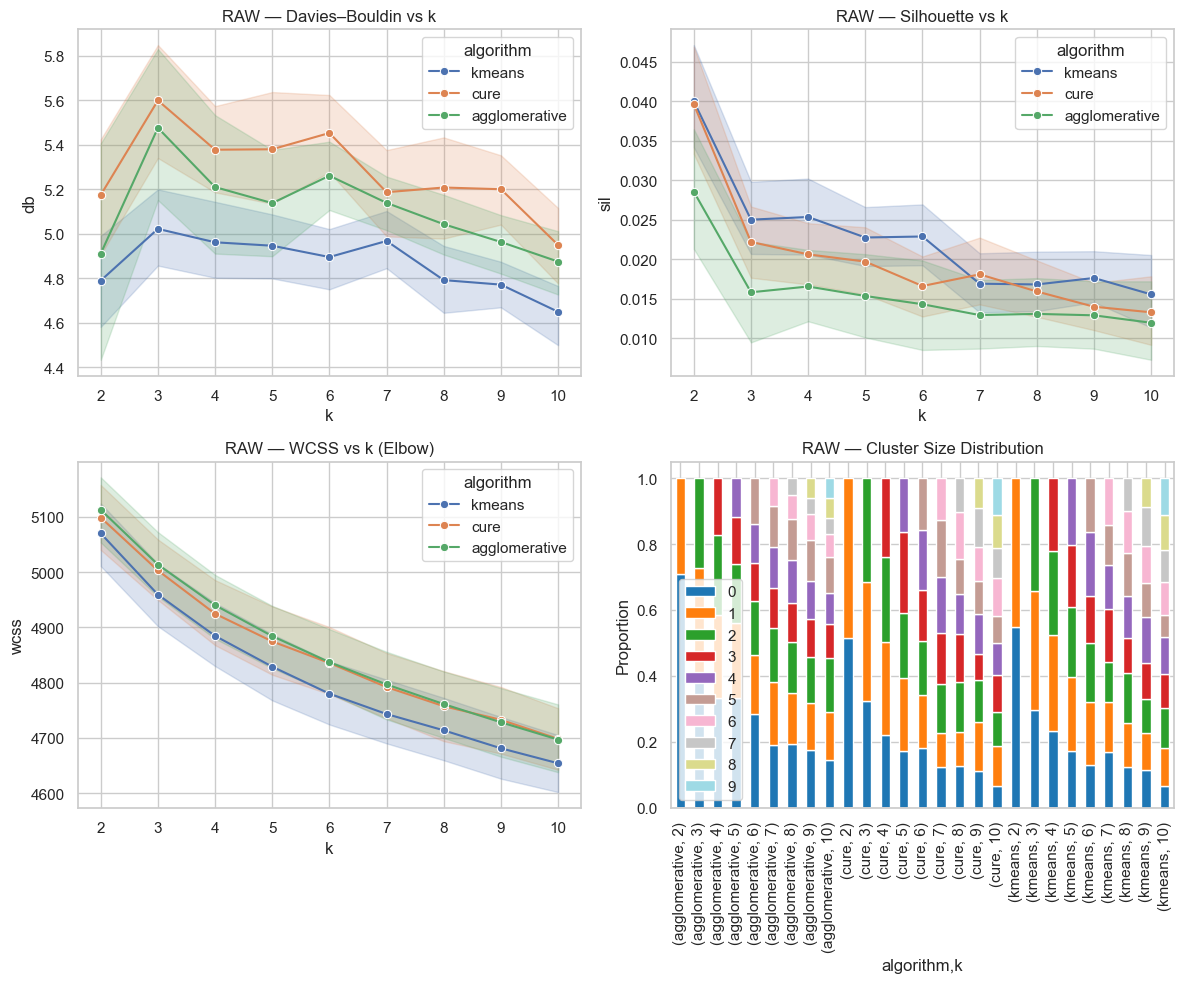

In [ ]:
df_db_raw, df_sil_raw, df_wcss_raw, df_sizes_raw = cu.evaluate_raw(
    sampled,
    k_values=k_values,
    algorithms=algorithms,
    n_reps=CURE_REPS,
    shrink=CURE_SHRINK,
    max_trials=N_SAMPLED
)

# numeric cluster columns (exclude metadata columns)
df_sizes_raw_f = df_sizes_raw.fillna(0)
numeric_cols = [c for c in df_sizes_raw_f.columns if c not in ["trial","algorithm","k"]]

grouped = df_sizes_raw_f.groupby(["algorithm","k"])[numeric_cols].mean()
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0)


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Davies–Bouldin (top-left)
sns.lineplot(data=df_db_raw, x="k", y="db", hue="algorithm", marker="o", ax=axes[0, 0])
axes[0, 0].set_title("RAW — Davies–Bouldin vs k")

# Silhouette (top-right)
sns.lineplot(data=df_sil_raw, x="k", y="sil", hue="algorithm", marker="o", ax=axes[0, 1])
axes[0, 1].set_title("RAW — Silhouette vs k")

# WCSS / Elbow (bottom-left)
sns.lineplot(data=df_wcss_raw, x="k", y="wcss", hue="algorithm", marker="o", ax=axes[1, 0])
axes[1, 0].set_title("RAW — WCSS vs k (Elbow)")

# Cluster size distribution (bottom-right)
grouped_pct.plot(kind="bar", stacked=True, colormap="tab20", ax=axes[1, 1])
axes[1, 1].set_title("RAW — Cluster Size Distribution")
axes[1, 1].set_ylabel("Proportion")

plt.tight_layout()
plt.show()


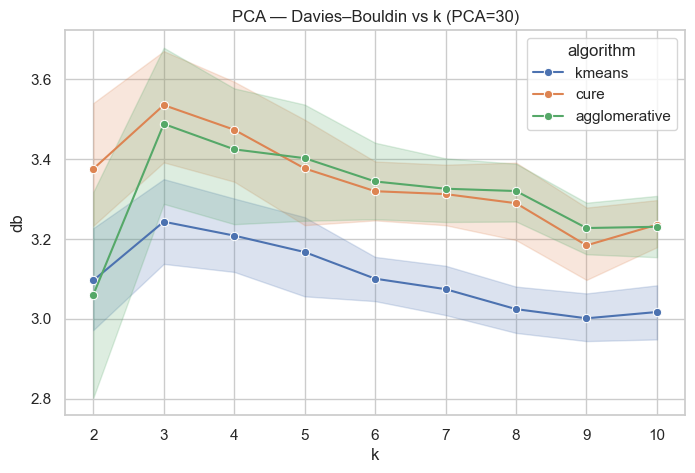

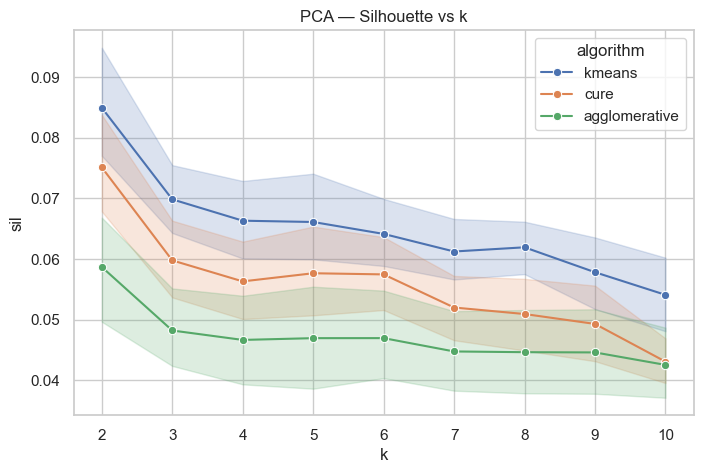

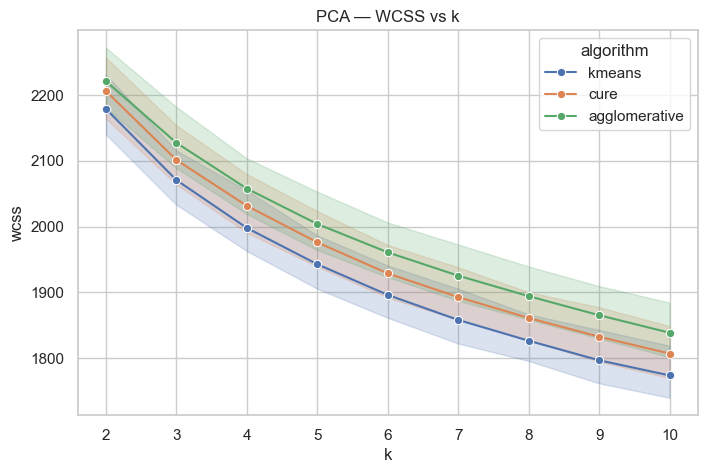

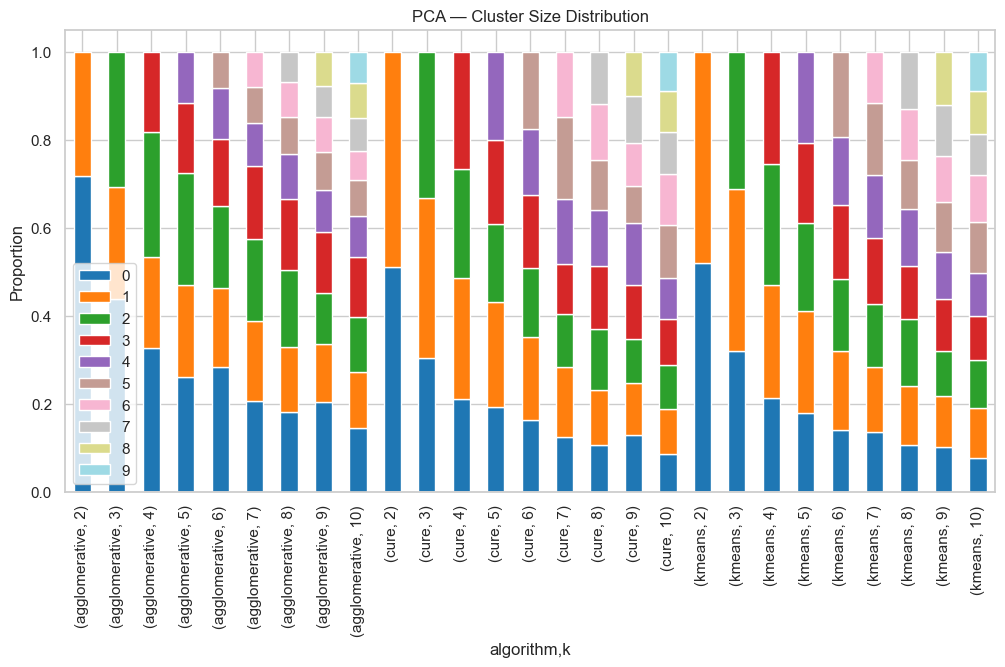

In [6]:
df_db_pca, df_sil_pca, df_wcss_pca, df_sizes_pca = cu.evaluate_pca(
    sampled,
    k_values=k_values,
    algorithms=algorithms,
    pca_dim=PCA_DIM,
    n_reps=CURE_REPS,
    shrink=CURE_SHRINK,
    max_trials=N_SAMPLED
)

plt.figure(figsize=(8,5))
sns.lineplot(data=df_db_pca, x="k", y="db", hue="algorithm", marker="o")
plt.title("PCA — Davies–Bouldin vs k (PCA=30)")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_sil_pca, x="k", y="sil", hue="algorithm", marker="o")
plt.title("PCA — Silhouette vs k")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_wcss_pca, x="k", y="wcss", hue="algorithm", marker="o")
plt.title("PCA — WCSS vs k")
plt.show()

df_sizes_pca_f = df_sizes_pca.fillna(0)

numeric_cols = [c for c in df_sizes_pca_f.columns if c not in ["trial","algorithm","k"]]

grouped = df_sizes_pca_f.groupby(["algorithm","k"])[numeric_cols].mean()
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0)

grouped_pct.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.title("PCA — Cluster Size Distribution")
plt.ylabel("Proportion")
plt.show()


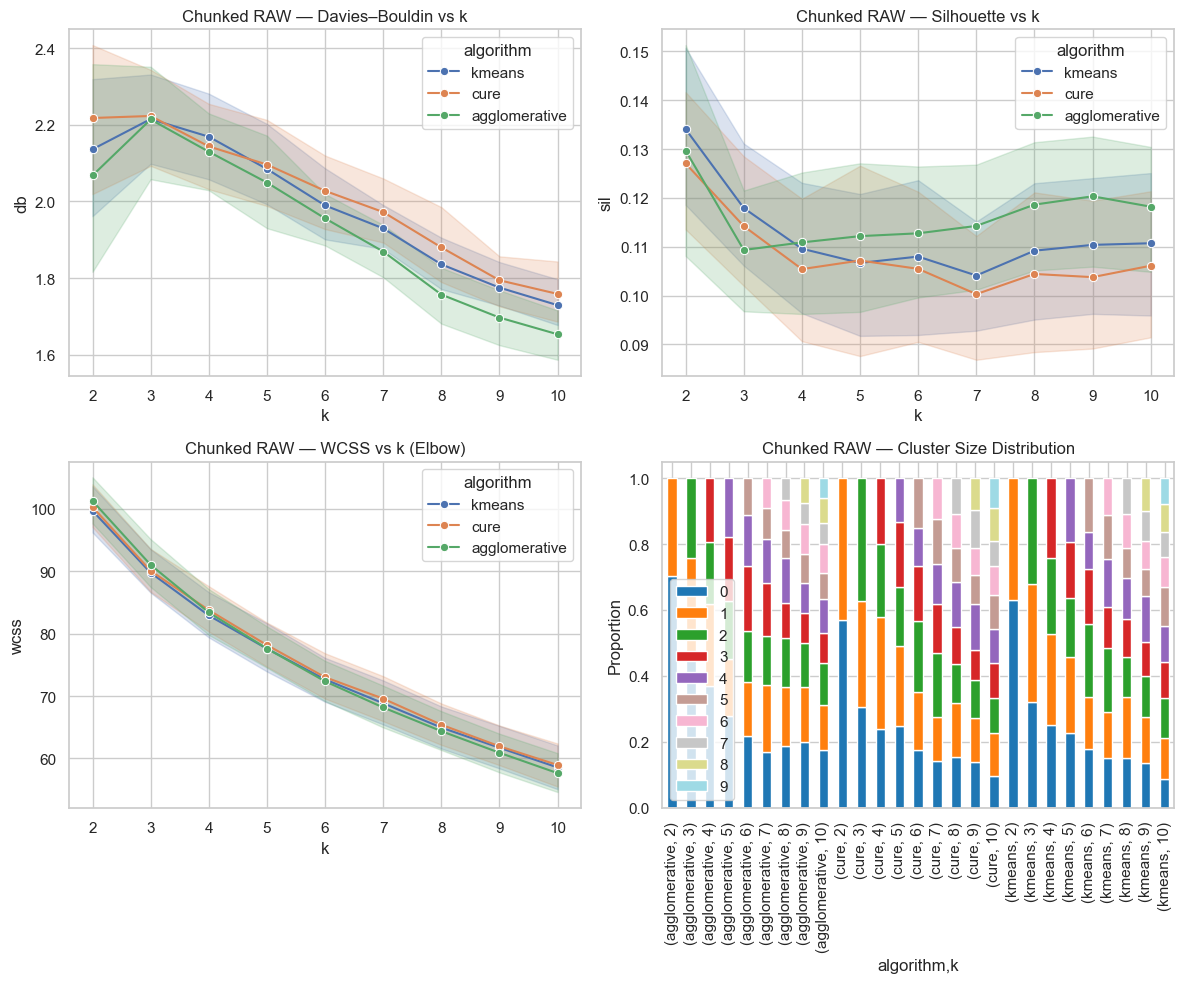

In [ ]:
df_db_chunk_raw, df_sil_chunk_raw, df_wcss_chunk_raw, df_sizes_chunk_raw = cu.evaluate_chunked_raw(
    sampled,
    k_values=k_values,
    algorithms=algorithms,
    window_size=WINDOW_SIZE,
    overlap=OVERLAP,
    pca_dim=None,      # raw chunked
    n_reps=CURE_REPS,
    shrink=CURE_SHRINK,
    max_trials=N_SAMPLED
)

# numeric cluster columns (exclude metadata columns)
df_sizes_chunk_raw_f = df_sizes_chunk_raw.fillna(0)
numeric_cols = [c for c in df_sizes_chunk_raw_f.columns if c not in ["trial","algorithm","k"]]

grouped = df_sizes_chunk_raw_f.groupby(["algorithm","k"])[numeric_cols].mean()
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0)


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Davies–Bouldin (top-left)
sns.lineplot(data=df_db_chunk_raw, x="k", y="db", hue="algorithm", marker="o", ax=axes[0, 0])
axes[0, 0].set_title("Chunked RAW — Davies–Bouldin vs k")

# Silhouette (top-right)
sns.lineplot(data=df_sil_chunk_raw, x="k", y="sil", hue="algorithm", marker="o", ax=axes[0, 1])
axes[0, 1].set_title("Chunked RAW — Silhouette vs k")

# WCSS / Elbow (bottom-left)
sns.lineplot(data=df_wcss_chunk_raw, x="k", y="wcss", hue="algorithm", marker="o", ax=axes[1, 0])
axes[1, 0].set_title("Chunked RAW — WCSS vs k (Elbow)")

# Cluster size distribution (bottom-right)
grouped_pct.plot(kind="bar", stacked=True, colormap="tab20", ax=axes[1, 1])
axes[1, 1].set_title("Chunked RAW — Cluster Size Distribution")
axes[1, 1].set_ylabel("Proportion")

plt.tight_layout()
plt.show()


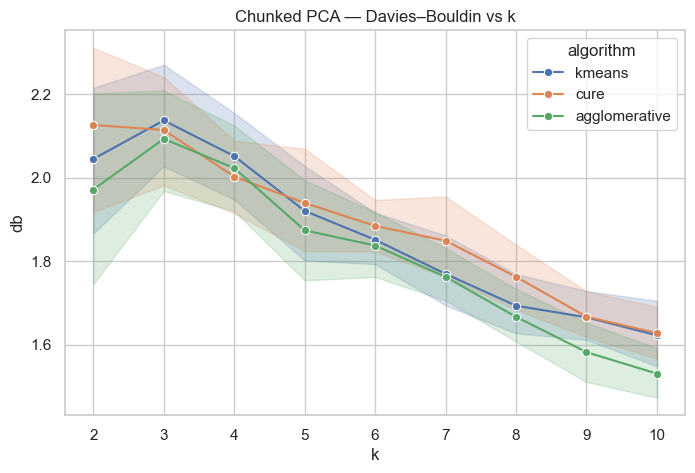

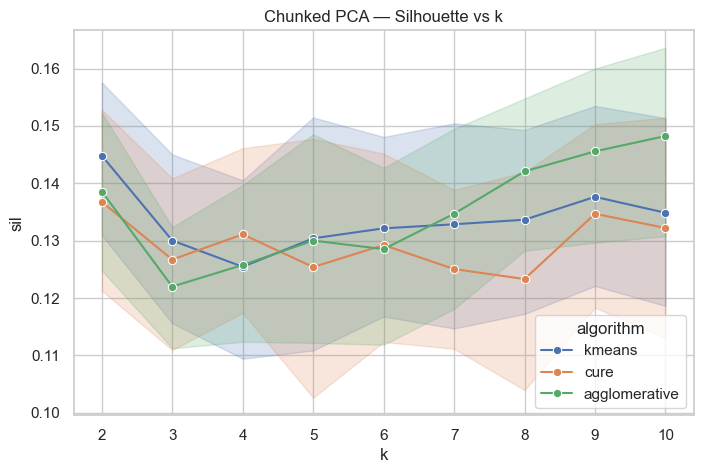

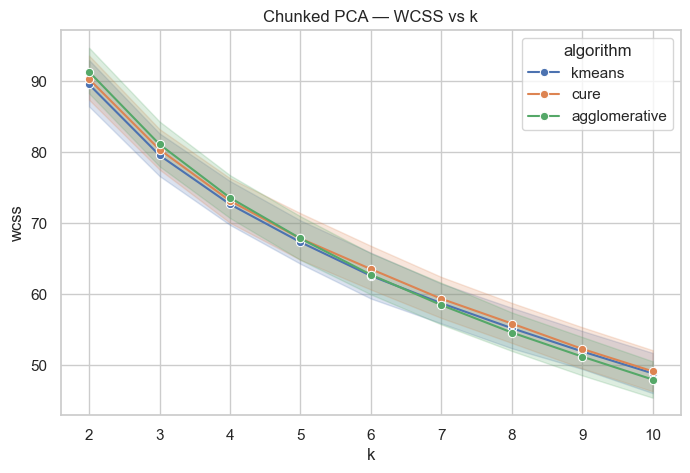

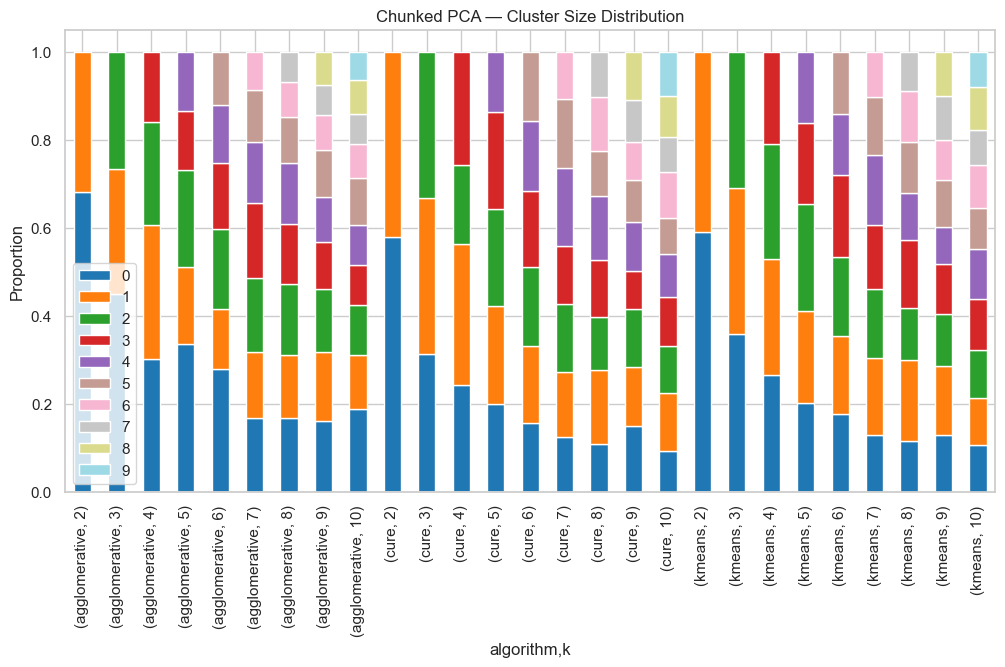

In [8]:
df_db_chunk_pca, df_sil_chunk_pca, df_wcss_chunk_pca, df_sizes_chunk_pca = cu.evaluate_chunked_pca(
    sampled,
    k_values=k_values,
    algorithms=algorithms,
    window_size=WINDOW_SIZE,
    pca_dim=PCA_DIM,
    overlap=OVERLAP,
    n_reps=CURE_REPS,
    shrink=CURE_SHRINK,
    max_trials=N_SAMPLED
)

plt.figure(figsize=(8,5))
sns.lineplot(data=df_db_chunk_pca, x="k", y="db", hue="algorithm", marker="o")
plt.title("Chunked PCA — Davies–Bouldin vs k")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_sil_chunk_pca, x="k", y="sil", hue="algorithm", marker="o")
plt.title("Chunked PCA — Silhouette vs k")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_wcss_chunk_pca, x="k", y="wcss", hue="algorithm", marker="o")
plt.title("Chunked PCA — WCSS vs k")
plt.show()

df_sizes_chunk_pca_f = df_sizes_chunk_pca.fillna(0)

numeric_cols = [c for c in df_sizes_chunk_pca_f.columns if c not in ["trial","algorithm","k"]]

grouped = df_sizes_chunk_pca_f.groupby(["algorithm","k"])[numeric_cols].mean()
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0)

grouped_pct.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.title("Chunked PCA — Cluster Size Distribution")
plt.ylabel("Proportion")
plt.show()


/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/erika/Desktop/Computational Tools for Data Science /.ve

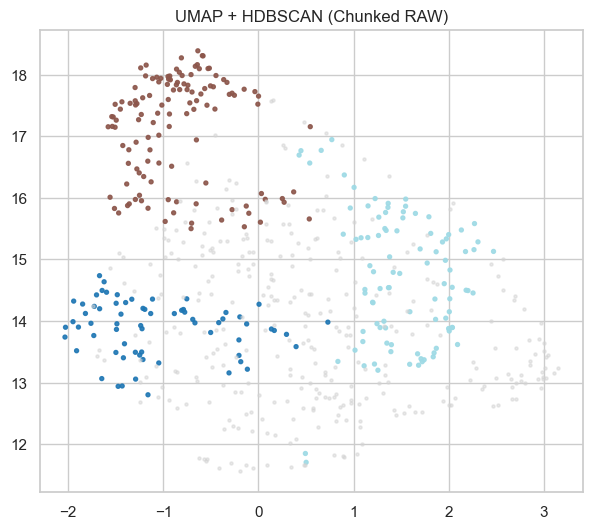

In [9]:
labels_raw, X_umap_cluster_raw, X_umap_plot_raw, meta_raw = cu.evaluate_umap_hdbscan(
    sampled,
    window_size=WINDOW_SIZE,
    overlap=0,
    pca_dim=None,
    max_trials=N_SAMPLED
)

meta_raw["cluster"] = labels_raw
meta_raw.head()

plt.figure(figsize=(7,6))
mask_noise = (labels_raw == -1)

plt.scatter(X_umap_plot_raw[~mask_noise,0], X_umap_plot_raw[~mask_noise,1],
            c=labels_raw[~mask_noise], cmap="tab20", s=8, alpha=0.9)
plt.scatter(X_umap_plot_raw[mask_noise,0], X_umap_plot_raw[mask_noise,1],
            c="lightgray", s=5, alpha=0.5)

plt.title("UMAP + HDBSCAN (Chunked RAW)")
plt.show()

